# Z-Peak Example

In [1]:
import numpy as np
%matplotlib inline
import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory(name="dataset", label="", categories=[], growth=True)
        dimu_mass_axis = hist.axis.Regular(name="dimu_mass", label="$\mu\mu$ Mass [GeV]", bins=50, start=20, stop=120)
        
        self.output = processor.dict_accumulator({
            'dimu_mass': hist.Hist(dataset_axis, dimu_mass_axis),
        })
    
    def process(self, events):    
        dataset = events.metadata["dataset"]
        
        mu = events.Muon
        dimu_neutral = mu[(ak.num(mu) == 2) & (ak.sum(mu.charge, axis=1) == 0)]
        dimu_mass = (dimu_neutral[:, 0] + dimu_neutral[:, 1]).mass
        
        self.output['dimu_mass'].fill(dataset=dataset, dimu_mass=dimu_mass)
        
        return self.output

    def postprocess(self, accumulator):
        pass

In [3]:
from dask.distributed import Client

client = Client("tls://localhost:8786")

In [4]:
fileset = {'DoubleMu' : ['root://xcache//store/data/Run2018A/DoubleMuon/NANOAOD/02Apr2020-v1/30000/0555868D-6B32-D249-9ED1-6B9A6AABDAF7.root',
                        'root://xcache//store/data/Run2018A/DoubleMuon/NANOAOD/02Apr2020-v1/30000/07796DC0-9F65-F940-AAD1-FE82262B4B03.root',
                        'root://xcache//store/data/Run2018A/DoubleMuon/NANOAOD/02Apr2020-v1/30000/09BED5A5-E6CC-AC4E-9344-B60B3A186CFA.root']}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                      )

output = run(fileset, "Events", processor_instance=Processor())

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff6cf883d90>, errorbar=None, legend_artist=None)]

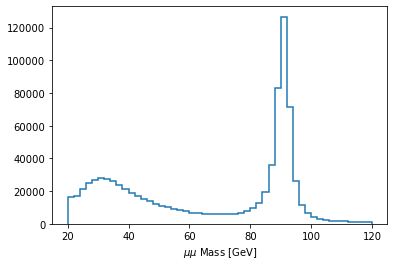

In [6]:
output['dimu_mass'].plot1d()